# AstroNuc $-$ Line Profile Shape Exploration Notebook

This notebook is designed to give intuition (in a 1D, spherically symmetric / angle averaged sense) for\
how different elemental distributions are imprinted in the shape of emission lines profiles.

Here we focus on the differing signatures from thermonuclear SN (SN Ia) explosion models, but the principles apply broadly.\
(Care should be given to expectations for 3D effects, though, which might deviate from our 1D assumption more in certain types of objects.)

All angle-averaged model data were obtained from <a href="https://hesma.h-its.org/" target="_blank" rel="noopener noreferrer">
  HESMA</a> (HEidelberg Supernova Model Archive).

## Load dependencies & data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from matplotlib.ticker import ScalarFormatter, MultipleLocator, NullFormatter
import pandas as pd
import json
from scipy.integrate import quad
import glob
import os


z_24gy = 0.000437 # redshift of SN 2024gy host galaxy

/var/folders/20/lgg891h106qgf648l2wp1kgw0000gn/T/ipykernel_46760/3795057992.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load models

In [2]:
def load_model_to_df(f, isotopes):
    """
    Read either a .json or .dat model file and return a standardized DataFrame with:
      - velocity  (km/s)
      - density   (g/cm^3)
      - one column per isotope in `isotopes` (mass fractions)

    Assumptions:
      - JSON: data live in model[name]['data'], where name is derived from filename as in your code.
              velocity computed from radius/time (converted to km/s via *1e-5).
              isotope keys are usually x{isotope}, except:
                C12 -> xXc
                O16 -> xXo16
      - DAT: whitespace-delimited columns including:
              'Velocity[km/s]', 'Density[g/cm^3]', and lowercase isotope columns (e.g. 'ni56').
    """
    ext = os.path.splitext(f)[1].lower()

    if ext == ".json":
        with open(f, "r") as file:
            model = json.load(file)

        name = "_".join(os.path.basename(f).split("_")[:-1])
        if name not in model:
            raise KeyError(
                f"Could not find top-level key '{name}' in JSON. "
                f"Available keys: {list(model.keys())[:10]}{'...' if len(model.keys()) > 10 else ''}"
            )
        if "data" not in model[name]:
            raise KeyError(f"JSON model['{name}'] does not contain a 'data' field.")

        model_df = pd.json_normalize(model[name]["data"])

        # Map desired isotope -> JSON column name
        json_col_map = {}
        for iso in isotopes:
            if iso == "C12":
                json_col_map[iso] = "xXc"
            elif iso == "O16":
                json_col_map[iso] = "xXo16"
            else:
                json_col_map[iso] = f"x{iso}"

        required_base = ["radius", "density", "time"]
        missing_base = [c for c in required_base if c not in model_df.columns]
        if missing_base:
            raise KeyError(f"JSON is missing required columns: {missing_base}. Found: {list(model_df.columns)}")

        missing_iso_cols = [iso for iso, col in json_col_map.items() if col not in model_df.columns]
        if missing_iso_cols:
            missing_pairs = {iso: json_col_map[iso] for iso in missing_iso_cols}
            raise KeyError(f"JSON is missing isotope columns: {missing_pairs}. Found: {list(model_df.columns)}")

        df = pd.DataFrame()
        df["velocity"] = (model_df["radius"] / model_df["time"]) * 1e-5  # to km/s (your convention)
        df["density"] = model_df["density"]
        for iso, col in json_col_map.items():
            df[iso] = model_df[col]

        return df

    else:
        # Treat as whitespace-delimited table (.dat, .txt, etc.)
        model_df = pd.read_csv(f, delimiter=r"\s+")

        vel_col = "Velocity[km/s]"
        rho_col = "Density[g/cm^3]"
        if vel_col not in model_df.columns or rho_col not in model_df.columns:
            raise KeyError(
                f"DAT is missing required columns '{vel_col}' and/or '{rho_col}'. "
                f"Found: {list(model_df.columns)}"
            )

        # Map desired isotope -> DAT column name (lowercase)
        dat_col_map = {iso: iso.lower() for iso in isotopes}

        missing_iso_cols = [iso for iso, col in dat_col_map.items() if col not in model_df.columns]
        if missing_iso_cols:
            missing_pairs = {iso: dat_col_map[iso] for iso in missing_iso_cols}
            raise KeyError(f"DAT is missing isotope columns: {missing_pairs}. Found: {list(model_df.columns)}")

        df = pd.DataFrame()
        df["velocity"] = model_df[vel_col]
        df["density"] = model_df[rho_col]
        for iso, col in dat_col_map.items():
            df[iso] = model_df[col]

        return df


# Part 1: Let's explore a delayed detonation (DDT) model

In [3]:
# First let's choose the isotopes we're interested in exploring

isotopes = ['C12', 'O16', 'Ne22', 'S32', 'Si28', 'Ar36', 'Ni56', 'Ni58']  # <-- good starting list covering LMEs, IMEs, and IGEs, but feel free to modify

In [4]:
fname = 'HESMA_models/ddt/ddt_2013_n100_hesma.json'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_df = load_model_to_df(fname, isotopes)

### Plot isotope abundances
Where are the different element groups concentrated radially?

(0.0, 0.9487849661576979)

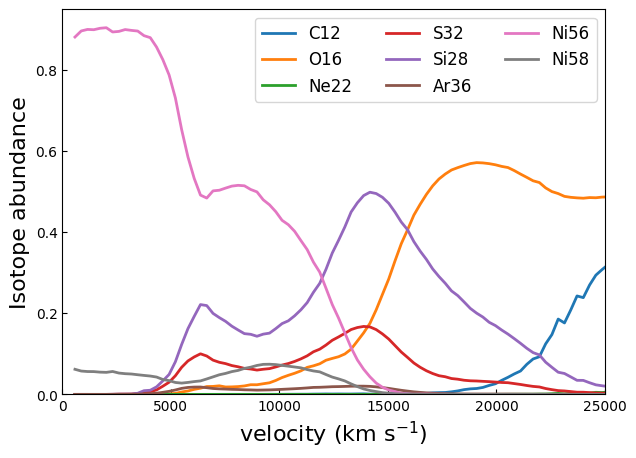

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

normalize = False  #  <-- change this to True if you want the abundances each normalized

for i in isotopes:
    if normalize == True:
        ax.plot(model_df['velocity'], model_df[i]/np.max(model_df[i]), label='{}'.format(i), lw=2)
    else:
        ax.plot(model_df['velocity'], model_df[i], label='{}'.format(i), lw=2)

ax.set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
if normalize == True:
    ax.set_ylabel(r'Normalized isotope abundance', fontsize=16)
else:
    ax.set_ylabel(r'Isotope abundance', fontsize=16)
ax.legend(fontsize=12, ncol=3)
ax.tick_params(which='both', direction='in')


ax.set_xlim(0, 25_000)
ax.set_ylim(0, )



## Calculate the nebular line profile

<img src="nebular_line_diagram.png" width="800">

For an optically thin emitting region, the observed line profile is given by:\
$F_\nu(v) \propto \int_v^{v_{\rm max}} j_0(v)\,v\,{\rm d} v$
where $j_0(v)$ is the emissivity.

Then changing variables to cyclindrical coordinates: \
$F_\nu(v_\mathrm{los}) \propto \int_0^{2\pi} \int_0^{\sqrt{v_\mathrm{max}^2 - v_\mathrm{los}^2}} j_0(r, v_\mathrm{los},\phi)\,r\,{\rm d}r\,{\rm d}\phi$\
where $r^2 = v_x^2 + v_y^2$

Assuming axisymmetry about the line of sight turns the $\phi$ integral into a factor of $2\pi$ and we have:\
$F_\nu(v_\mathrm{los}) \propto \int_0^{\sqrt{v_\mathrm{max}^2 - v_\mathrm{los}^2}} j_0(r, v_\mathrm{los})\,r\,{\rm d}r$

Below we evaluate this integrate, assuming that emissivity $\propto$ density $\times$ abundance, ($j_0(v) \propto \rho \, \chi$).\
Note that this assumption is not fully correct, but it gives a pretty good estimate for the exploration we do here.


In [6]:
def nebular_profile(df, isotope):

    def find_rho(v, velocity, rho):
        return np.interp(v, velocity, rho)
    
    def find_X(v, velocity, abundance):
        return np.interp(v, velocity, abundance)
    
    def integrand_nebular(y, x, velocity, rho, abundance):
        v = np.sqrt(x**2 + y**2)
        return find_rho(v, velocity, rho) * find_X(v, velocity, abundance) * y
    
    def flux_density_nebular(x, y_min, y_max, velocity, rho, abundance):
        y_range = np.linspace(y_min, y_max, 1000)
        integrate_y = integrand_nebular(y_range, x, velocity, rho, abundance)
        return np.trapz(integrate_y, y_range)

    rho = np.array(df['density'])
    velocity = np.array(df['velocity'])
    abundance = np.array(df[isotope])

    x_max = max(velocity)
    x_array = np.linspace(-x_max,x_max,1000)
    y_min = 0
    y_max = np.sqrt(x_max**2 - x_array**2)

    flux_area_nebular = []
    for i in range(len(x_array)):
        flux_area_nebular.append(flux_density_nebular(x_array[i], y_min, y_max[i], velocity, rho, abundance))

    return x_array, (flux_area_nebular)/max(flux_area_nebular)

### Explore how the radial distribution of different elements affects the line profile shape

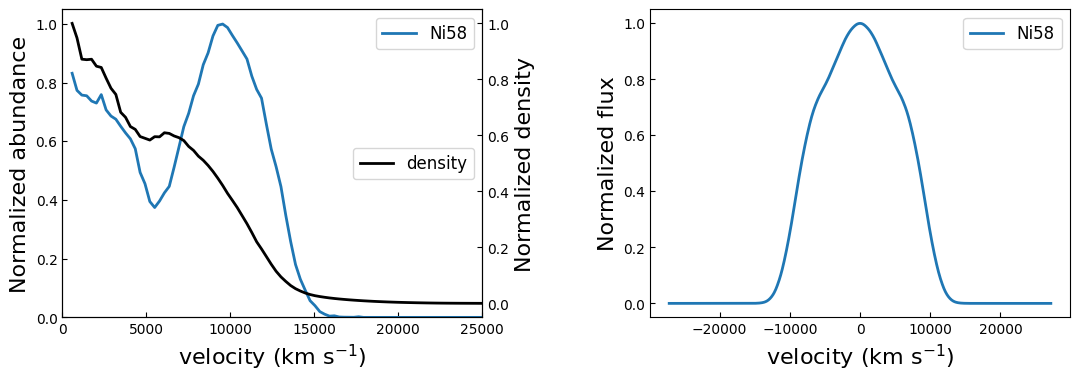

In [7]:
iso = ['Ni58',  ]  # <-- explore from your isotope list to see what kinds of different line profile shapes you get


fig, ax = plt.subplots(1, 2, figsize=(13, 4))

normalize = True
ax2 = ax[0].twinx()

for i in iso:
    if normalize == True:
        ax[0].plot(model_df['velocity'], model_df[i]/np.max(model_df[i]), label='{}'.format(i), lw=2)
        ax2.plot(model_df['velocity'], model_df['density']/np.max(model_df['density']), 'k', label='density'.format(i), lw=2)

    else:
        ax[0].plot(model_df['velocity'], model_df[i], label='{}'.format(i), lw=2)
        ax2.plot(model_df['velocity'], model_df['density']/np.max(model_df['density']), 'k', label='density'.format(i), lw=2)

    x, y = nebular_profile(model_df, i)
    ax[1].plot(x, y, label='{}'.format(i), lw=2)


ax[0].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
if normalize == True:
    ax[0].set_ylabel(r'Normalized abundance', fontsize=16)
else:
    ax[0].set_ylabel(r'Abundance', fontsize=16)
ax[0].legend(fontsize=12, ncol=2, loc='upper right')
ax[0].tick_params(which='both', direction='in')

ax[1].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
ax[1].set_ylabel(r'Normalized flux', fontsize=16)
ax[1].legend(fontsize=12, ncol=2)
ax[1].tick_params(which='both', direction='in')

ax2.set_ylabel(r'Normalized density', fontsize=16)
# ax2.set_yscale('log')  # <-- comment this in if you like log-space density better
ax2.legend(fontsize=12, loc='center right')
ax2.tick_params(which='both', direction='in')


ax[0].set_xlim(0, 25_000)
ax[0].set_ylim(0, )

fig.subplots_adjust(wspace=0.4)



# Part 2: Let's explore some other models

<img src="line_profiles+table_v2.png" width="1000">

### Delayed detonation (DDT)

In [8]:
fname = 'HESMA_models/ddt/ddt_2013_n100_hesma.json'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_ddt = load_model_to_df(fname, isotopes)

### Gravitationally confined detonation (DDT)

In [9]:
fname = 'HESMA_models/gcd/gcd_2021_r10_d1.0_isotopes.dat'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_gcd = load_model_to_df(fname, isotopes)

### Double detonation (DBLDET)

In [10]:
fname = 'HESMA_models/dbldet/doubledet_2021_m1002_1_isotopes.dat'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_dbldet = load_model_to_df(fname, isotopes)

### Violent merger (MERGER)

In [11]:
fname = 'HESMA_models/merger/merger_2012_11+09_hesma.json'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_merger = load_model_to_df(fname, isotopes)

### Deflagration (DEF)

In [12]:
fname = 'HESMA_models/def/def_2014_n1def_hesma.json'  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

model_def = load_model_to_df(fname, isotopes)

Compare the same isotope from different models to see how the distribution affects the line shape.

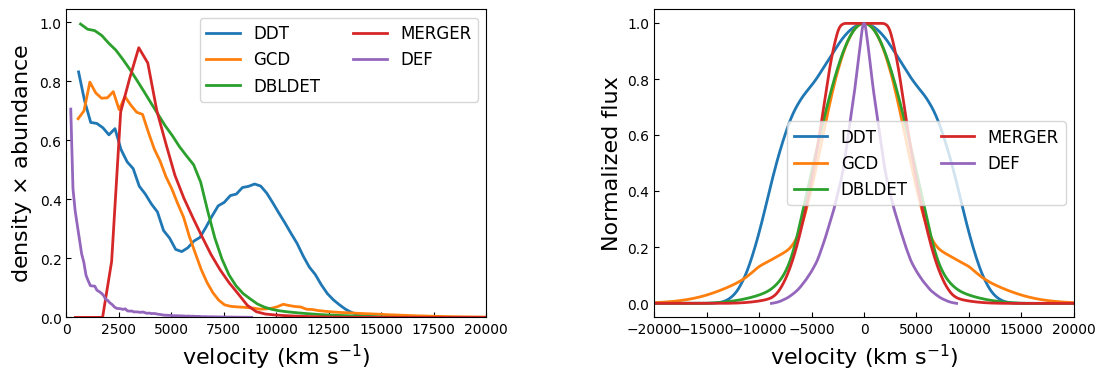

In [13]:
i = 'Ni58'  # <-- explore from your isotope list to see what kinds of different line profile shapes you get

models = [
    ("DDT", model_ddt),
    ("GCD", model_gcd),
    ("DBLDET", model_dbldet),
    ("MERGER", model_merger),
    ("DEF", model_def),
]

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

for label, model in models:
    ax[0].plot(
        model["velocity"],
        model[i] / np.max(model[i]) * model["density"] / np.max(model["density"]),
        label=label,
        lw=2,
    )
    x, y = nebular_profile(model, i)
    ax[1].plot(x, y, label=label, lw=2)


ax[0].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
ax[0].set_ylabel(r'density $\times$ abundance', fontsize=16)
ax[0].legend(fontsize=12, ncol=2, loc='upper right')
ax[0].tick_params(which='both', direction='in')

ax[1].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
ax[1].set_ylabel(r'Normalized flux', fontsize=16)
ax[1].legend(fontsize=12, ncol=2)
ax[1].tick_params(which='both', direction='in')


ax[0].set_xlim(0, 20_000)
ax[1].set_xlim(-20_000, 20_000)
ax[0].set_ylim(0, )

fig.subplots_adjust(wspace=0.4)



Compare across models and isotopes --> change up the models and isotopes you plot.\
*Hint*: what do you notice about O in the MERGER model?

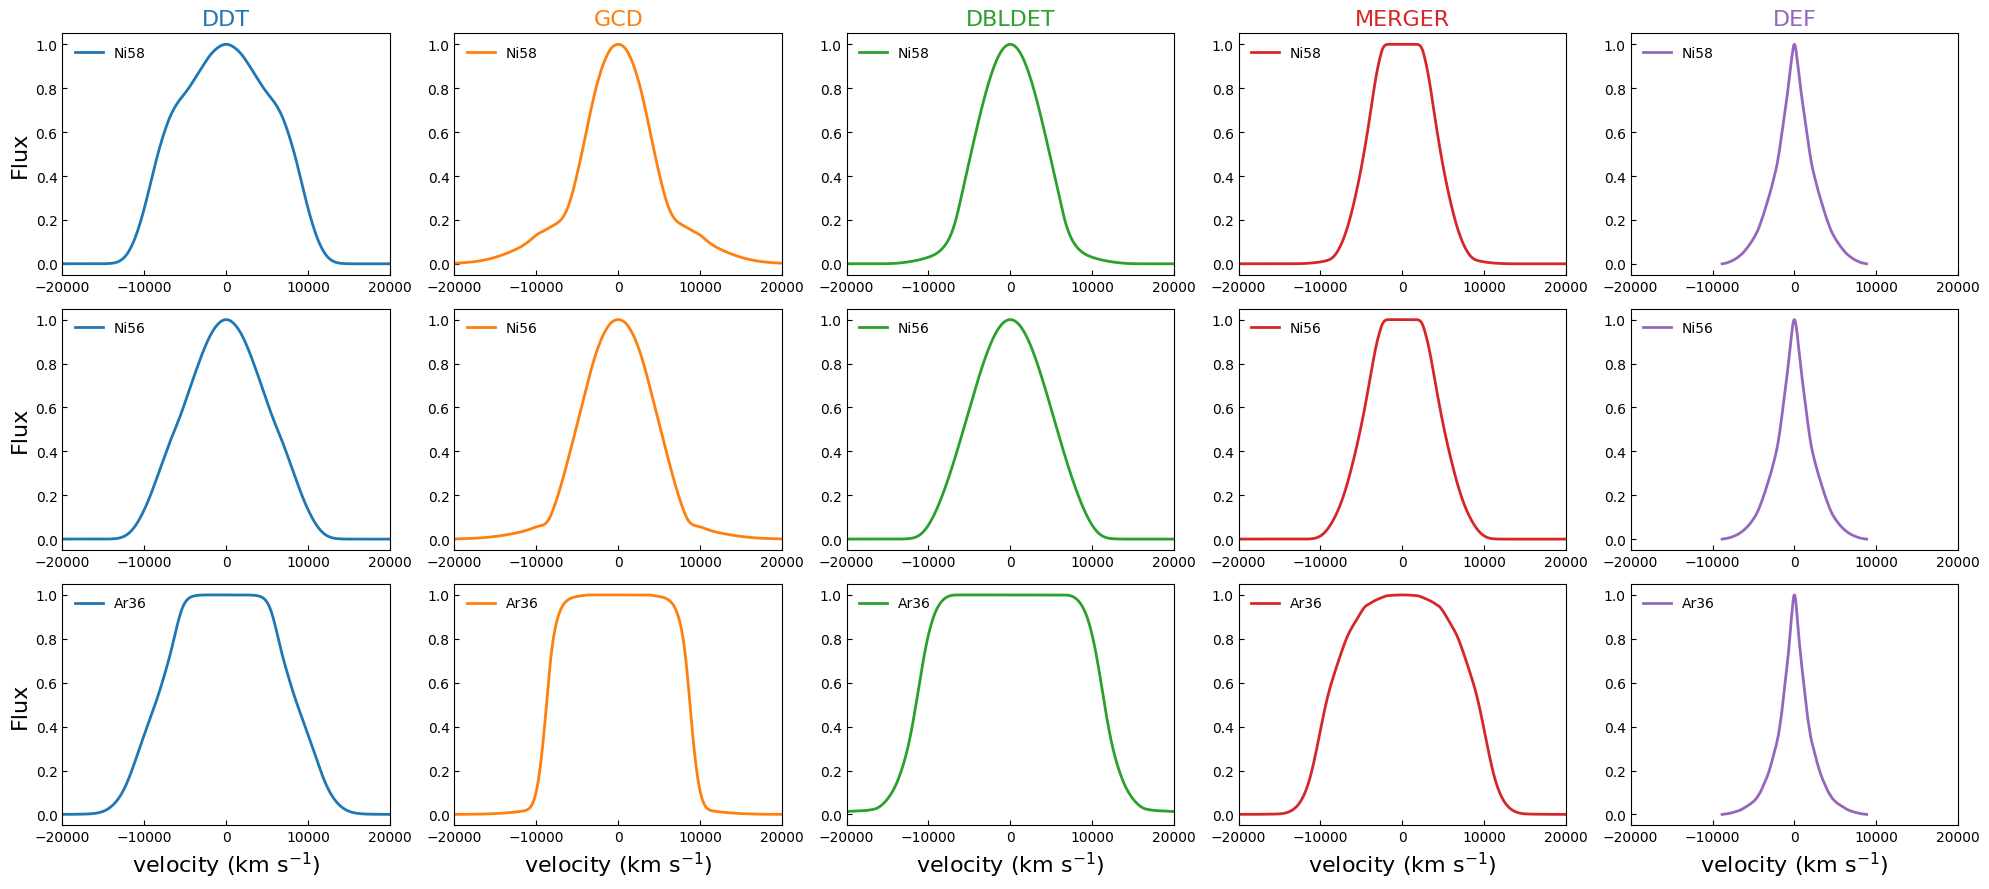

In [14]:
isos = ['Ni58', 'Ni56', 'Ar36', ]  # <-- explore from your isotope list to see what kinds of different line profile shapes you get

n = len(isos)   # rows
m = len(models)   # columns
v_max = 20_000

fig, axes = plt.subplots(
    n, m,
    figsize=(4*m, 3*n),
    sharex=True
)

# If n or m could be 1, this makes indexing consistent
axes = axes.reshape(n, m)

colors = plt.cm.tab10.colors[:m]

for i in range(n):
    for j in range(m):
        ax = axes[i, j]
        x, y = nebular_profile(models[j][1], isos[i])
        ax.plot(x, y, color=colors[j], label=isos[i], lw=2)
        if i == 0:
            ax.set_title(models[j][0], color=colors[j], fontsize=16)
        ax.set_xlim(-v_max, v_max)
        ax.tick_params(which='both', direction='in', labelbottom=True)
        ax.legend(loc='upper left', frameon=False)

for ax in axes[-1, :]:
    ax.set_xlabel(r"velocity (km s$^{-1}$)", fontsize=16)
for ax in axes[:, 0]:
    ax.set_ylabel(r"Flux", fontsize=16)

fig.tight_layout()

# Part 3: Dig deeper into variations within a model type (optional)

### Grab files
Choose a specific type of explosion model to investigate variations: ddt, dbldet, gcd, merger, def

In [15]:
model_type = 'ddt'  #  <-- change this to the one you want to explore

fnames = glob.glob(f'HESMA_models/{model_type}/*')  # <-- delayed detonation with 100 ignition points from Seitenzahl et al. 2013 (angle-averaged)

models_ext = [(f, load_model_to_df(f, isotopes)) for f in fnames]

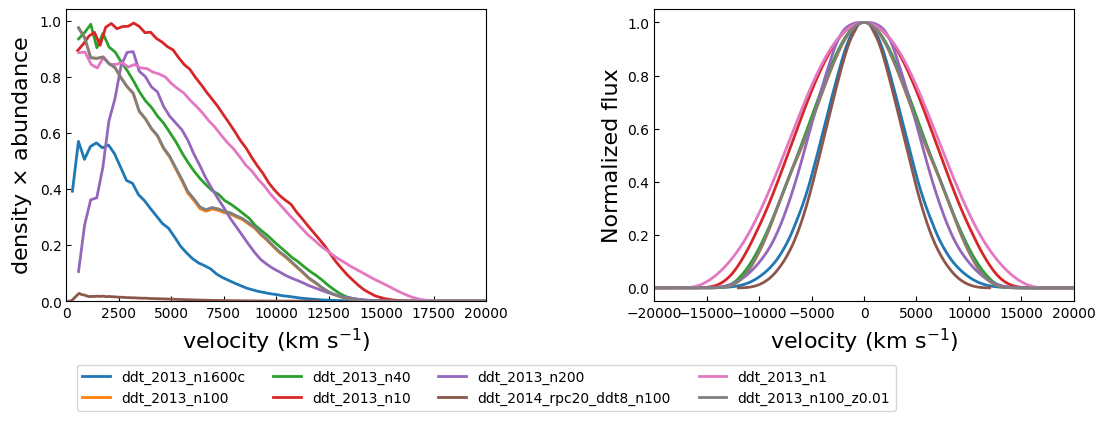

In [16]:
i = 'Ni56'  # <-- explore from your isotope list to see what kinds of different line profile shapes you get


fig, ax = plt.subplots(1, 2, figsize=(13, 4))

for label, model in models_ext:
    label = "_".join(label.split('/')[-1].split('_')[:-1])
    ax[0].plot(
        model["velocity"],
        model[i] / np.max(model[i]) * model["density"] / np.max(model["density"]),
        label=label,
        lw=2,
    )
    x, y = nebular_profile(model, i)
    ax[1].plot(x, y, label=label, lw=2)


ax[0].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
ax[0].set_ylabel(r'density $\times$ abundance', fontsize=16)
# ax[0].legend(fontsize=12, ncol=2, loc='upper right')
ax[0].tick_params(which='both', direction='in')

ax[1].set_xlabel(r'velocity (km s$^{-1}$)', fontsize=16)  #  <-- for SN, the velocity is the radial coordinate (homologous expansion r = vt)
ax[1].set_ylabel(r'Normalized flux', fontsize=16)
ax[1].tick_params(which='both', direction='in')

ax[0].legend(
    loc="lower center",
    bbox_to_anchor=(1.0, -0.4),
    ncol=4
)

fig.subplots_adjust(bottom=0.15)


ax[0].set_xlim(0, 20_000)
ax[1].set_xlim(-20_000, 20_000)
ax[0].set_ylim(0, )

fig.subplots_adjust(wspace=0.4)



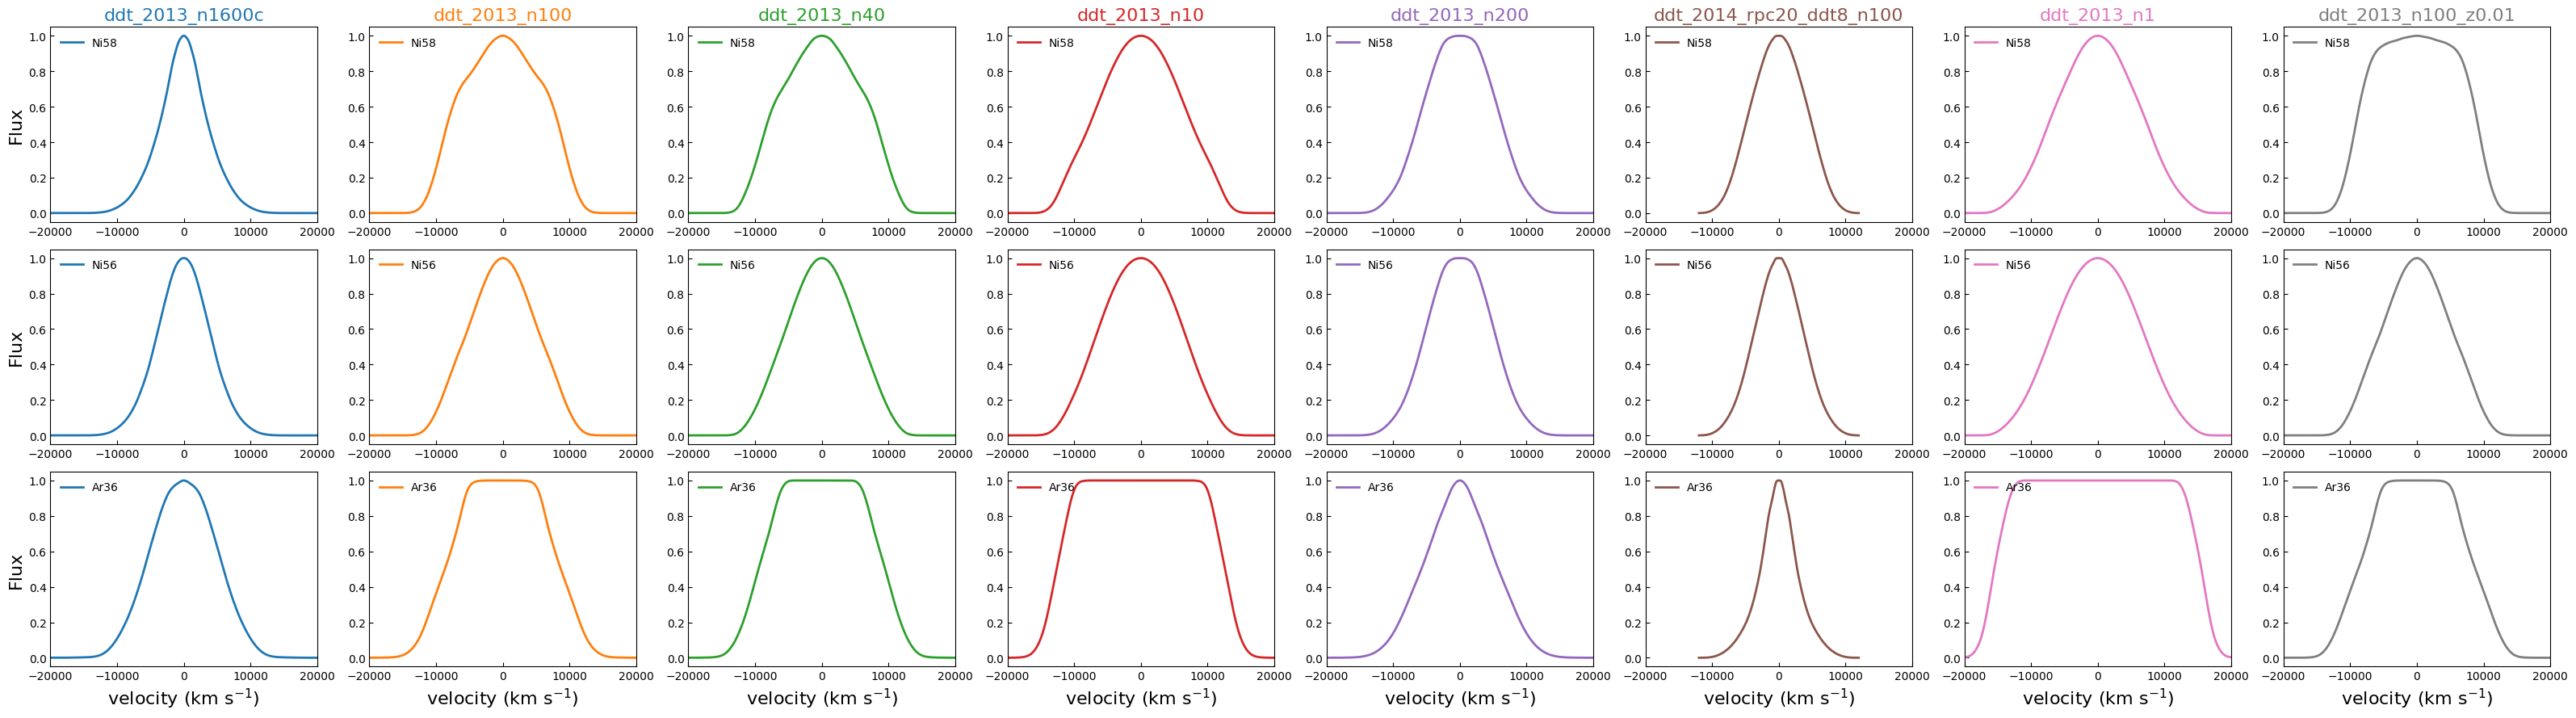

In [17]:
isos = ['Ni58', 'Ni56', 'Ar36', ]  # <-- explore from your isotope list to see what kinds of different line profile shapes you get

n = len(isos)   # rows
m = len(models_ext)   # columns
v_max = 20_000

fig, axes = plt.subplots(
    n, m,
    figsize=(4*m, 3*n),
    sharex=True
)

# If n or m could be 1, this makes indexing consistent
axes = axes.reshape(n, m)

colors = plt.cm.tab10.colors[:m]

for i in range(n):
    for j in range(m):
        title = "_".join(models_ext[j][0].split('/')[-1].split('_')[:-1])
        ax = axes[i, j]
        x, y = nebular_profile(models_ext[j][1], isos[i])
        ax.plot(x, y, color=colors[j], label=isos[i], lw=2)
        if i == 0:
            ax.set_title(title, color=colors[j], fontsize=16)
        ax.set_xlim(-v_max, v_max)
        ax.tick_params(which='both', direction='in', labelbottom=True)
        ax.legend(loc='upper left', frameon=False)

for ax in axes[-1, :]:
    ax.set_xlabel(r"velocity (km s$^{-1}$)", fontsize=16)
for ax in axes[:, 0]:
    ax.set_ylabel(r"Flux", fontsize=16)

fig.tight_layout()

# Part 4: Make an animation (optional)
Note: this is only an approximation, given that all models are 1D and we assume emissivity $\propto$ abundance $\times$ density (which is not entirely accurate, but reasonable for our purposes).

### Install imageio-ffmpeg and tqdm if you don't already have them

In [18]:
# !pip install imageio imageio-ffmpeg

In [19]:
# !pip install tqdm

In [20]:
# Import additional plotting dependencies

import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.animation import FFMpegWriter
import imageio
from tqdm.auto import tqdm
from matplotlib.cm import get_cmap

### Colors (or define yours)

In [21]:
# Some colors/colormaps that I like, but you can define your own!

color_red = '#DC050C'
gold_orange = (0.976, 0.629, 0.075)

def lighten_inferno(min_value=0.1, N=256):
    """
    Create a lighter version of inferno by skipping the darkest end.
    min_value: float in [0,1], how much of the dark end to skip (e.g., 0.05)
    """
    base = get_cmap('inferno')(np.linspace(min_value, 1.0, N))
    return ListedColormap(base)

### Animation making code

In [22]:
def make_circle_renderer(
    model,
    isotope,
    rmax,
    v_array,
    *,
    cmap="plasma",
    resolution=600,                 # 600 is usually plenty; 1000 is slow
    contrast_color="white",
    colors=("magenta", "white", "red"),
    observer_path="observer_black_to_white.png",
):
    """
    Returns (fig, update_frame) where update_frame(i, j) updates artists in-place.

    Requires:
      - nebular_profile(model, isotope) -> (v_prof, f_prof)
    """

    # --- cache model arrays for fast interp ---
    v_model = np.asarray(model["velocity"], float)
    em_model = np.asarray(model["density"], float) * np.asarray(model[isotope], float)

    # --- cache 1D profile on v_array ONCE ---
    v_prof, f_prof = nebular_profile(model, isotope)
    flux_on_v = np.interp(v_array, v_prof, f_prof)

    # --- cache the "positive side" sample points ONCE ---
    v_raw = v_array[(v_array >= 0) & (v_array <= rmax)]

    # --- cache colormap + a reusable normalizer object ---
    cmap_obj = plt.get_cmap(cmap)
    norm = Normalize()

    # --- cache a unit disk grid ONCE (covers both disks) ---
    # unit square in [-1, 1] x [-1, 1], with radius R in [0, sqrt(2)]
    u = np.linspace(-1.0, 1.0, resolution)
    U, V = np.meshgrid(u, u)
    R_unit = np.sqrt(U**2 + V**2)
    mask_unit = (R_unit <= 1.0)

    # Preallocate RGBA buffers to avoid realloc each frame
    rgba_big = np.zeros((resolution, resolution, 4), dtype=np.float32)
    rgba_small = np.zeros((resolution, resolution, 4), dtype=np.float32)

    # --- build figure ONCE ---
    fig = plt.figure(figsize=(10, 5), layout="constrained", facecolor="black")
    subfigs = fig.subfigures(1, 3, width_ratios=(0.3, 1, 0.5))

    ax_left  = subfigs[0].subplots(1, 1)
    ax_mid   = subfigs[1].subplots(1, 1)
    ax_right = subfigs[2].subplots(2, 1)

    for ax in (ax_left, ax_mid, ax_right[0], ax_right[1]):
        ax.set_facecolor("black")

    # Static decorations (draw once)
    ax_mid.annotate(
        "", xy=(-rmax * 1.1, 0), xytext=(rmax * 1.1, 0),
        arrowprops=dict(arrowstyle="<->", color=contrast_color)
    )
    ax_mid.vlines([-rmax, 0, rmax], -0.05 * rmax, 0.05 * rmax, color=contrast_color, lw=1)
    ax_mid.text(-rmax, -0.2 * rmax, "$-$v", fontsize=20, ha="center", color=contrast_color)
    ax_mid.text(0,     -0.2 * rmax, "0",    fontsize=20, ha="center", color=contrast_color)
    ax_mid.text(rmax,  -0.2 * rmax, "v",    fontsize=20, ha="center", color=contrast_color)

    ax_mid.set_xlim(-rmax * 1.1, rmax * 1.1)
    ax_mid.set_ylim(-rmax * 1.1, rmax * 1.1)
    ax_mid.set_title("line-of-sight", fontsize=18, color="white")

    ax_right[0].set_title("cross-section", fontsize=18, color="white")
    ax_right[1].set_xlabel("velocity", fontsize=18, color="white")
    ax_right[1].set_ylabel("flux", fontsize=18, color="white")
    ax_right[1].set_xlim(-rmax * 1.1, rmax * 1.1)
    ax_right[1].set_ylim(0, rmax * 1.1)
    ax_right[1].set_xticks([-rmax, 0, rmax])
    ax_right[1].set_xticklabels([r"$-$v", "0", "v"], fontsize=16, color="white")
    ax_right[1].set_yticklabels([], fontsize=16, color="white")
    ax_right[1].tick_params(colors="white", direction='in')
    for side in ("top", "right"):
        ax_right[1].spines[side].set_visible(False)
    for side in ("bottom", "left"):
        ax_right[1].spines[side].set_color("white")
        ax_right[1].spines[side].set_linewidth(1.5)

    # remove ticks/spines for image panels
    for ax in (ax_mid, ax_right[0], ax_left):
        ax.set_xticks([]); ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_visible(False)

    ax_left.set_xlim(0, 5)
    ax_left.set_ylim(-10, 10)
    ax_left.set_xticks([]); ax_left.set_yticks([])

    # Observer image ONCE
    observer = mpimg.imread(observer_path)
    imagebox = OffsetImage(observer, zoom=0.35)
    ax_left.add_artist(AnnotationBbox(imagebox, (3.5, 0), frameon=False))

    # Artists that will update each frame
    im_big = ax_mid.imshow(
        rgba_big, extent=[-rmax, rmax, -rmax, rmax], origin="lower", interpolation="nearest"
    )
    im_small = ax_right[0].imshow(
        rgba_small, extent=[-rmax, rmax, -rmax, rmax], origin="lower", interpolation="nearest"
    )

    # LOS vertical line (update x + y-lims)
    los_line = ax_mid.vlines(0.0, -rmax, rmax, colors=colors[2], lw=2)

    # Cross-section border circle (update radius)
    border_circle = plt.Circle((0, 0), rmax, color=colors[2], fill=False, lw=3)
    ax_right[0].add_patch(border_circle)

    # Flux curve + vertical marker (update data)
    # Flux curve
    (flux_line,) = ax_right[1].plot([], [], color=colors[0], lw=3)
    
    # Vertical marker as a Line2D (not vlines)
    (flux_vline,) = ax_right[1].plot([], [], color=colors[2], lw=3)


    def _radial_rgba_into(values, out_rgba, radius, vmin, vmax):
        """
        Fill out_rgba (H,W,4) for a disk of given radius using cached unit grid.
        values are sampled on [0, radius] (we'll treat them as defined on r/radius in [0,1]).
        """
        # Interpolate emissivity as a function of normalized radius (R_unit in [0,1] inside disk)
        xp = np.linspace(0.0, 1.0, len(values))
        vals = np.interp(R_unit.ravel(), xp, values).reshape(R_unit.shape)

        norm.vmin = vmin
        norm.vmax = vmax

        rgb = cmap_obj(norm(vals))[..., :3]
        out_rgba[..., :3] = rgb
        out_rgba[..., 3] = mask_unit.astype(np.float32)

    def update_frame(i, j):
        # emissivity along v_raw (0..rmax) from model (cached v_model/em_model)
        em_raw = np.interp(v_raw, v_model, em_model)
        vmin = float(np.min(em_raw) * 0.9)
        vmax = float(np.max(em_raw) * 1.1)

        # big disk image
        _radial_rgba_into(em_raw, rgba_big, rmax, vmin, vmax)
        im_big.set_data(rgba_big)

        # LOS line
        yhi = np.sqrt(max(rmax**2 - i**2, 0.0))
        los_line.set_segments([[(i, -yhi), (i, yhi)]])

        # cross-section disk
        y_max = yhi
        if y_max <= 0:
            y_max = 1e-6

        y_arr = np.linspace(0.0, y_max, 100)
        r_arr = np.sqrt(y_arr**2 + i**2)
        em_arr = np.interp(r_arr, v_model, em_model)

        _radial_rgba_into(em_arr, rgba_small, y_max, vmin, vmax)
        im_small.set_data(rgba_small)
        im_small.set_extent([-y_max, y_max, -y_max, y_max])

        border_circle.set_radius(y_max)
        ax_right[0].set_xlim(-rmax * 1.1, rmax * 1.1)
        ax_right[0].set_ylim(-rmax * 1.1, rmax * 1.1)

        # flux panel
        flux_line.set_data(v_array[: j + 1], flux_on_v[: j + 1] * rmax)
        
        y_top = float(flux_on_v[j] * rmax)
        flux_vline.set_data([i, i], [0.0, y_top])

        return fig

    return fig, update_frame


## Set up: choose your model, isotope, and velocity array

In [23]:
f = 'HESMA_models/ddt/ddt_2013_n100_hesma.json'  #  <-- replace with the model you want
model_animate = load_model_to_df(f, isotopes)

isotope = "Ar36"  # <-- choose your isotope of choice

In [24]:
# Set up your velocity grid (for finer velocity steps, make N_steps bigger)

vmax = 20_000  # km/s
N_steps = 100  # <-- 200 is plenty
v_array = np.linspace(-vmax, vmax, N_steps)

### Run

In [25]:
f_out = "nebular_animation.mp4"  # <-- choose your output filename

fig, update = make_circle_renderer(
    model_animate, isotope, vmax, v_array,
    cmap=lighten_inferno(),  #  <-- replace with your fave color map if you want
    colors=(gold_orange, "white", color_red),  #  <-- you can play with these colors too
    resolution=600,
)

nframes = len(v_array) - 1

with imageio.get_writer(f_out, fps=20) as writer:
    for j, i in tqdm(list(enumerate(v_array[:-1])), total=nframes, desc="Rendering frames"):
        update(i, j)
        fig.canvas.draw()

        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        writer.append_data(frame)

plt.close(fig)
print(f"Saved {f_out}")

/var/folders/20/lgg891h106qgf648l2wp1kgw0000gn/T/ipykernel_46760/1690054153.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = get_cmap('inferno')(np.linspace(min_value, 1.0, N))


Rendering frames:   0%|          | 0/99 [00:00<?, ?it/s]

/var/folders/20/lgg891h106qgf648l2wp1kgw0000gn/T/ipykernel_46760/608830955.py:17: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved nebular_animation.mp4


### Play the video!

In [26]:
from IPython.display import Video

Video(f_out, embed=True)